In [1]:
import pandas as pd
import numpy as np
from scipy import stats, special
from scipy.optimize import minimize 
import pingouin as pg

import pymc3 as pm
import arviz as az

import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
# Load Data
db = pd.read_csv('data/mon.csv')

# remove subjects with no lottery selections
badchoices = db[['sub','choice']].groupby('sub').sum()
badsubs = badchoices[badchoices['choice']<10].index.values
print("subs to remove for selecting only the ref", badsubs)

db = db[db['sub'].isin(badsubs) == False]

# add serial number for participants
db['subn'] = db['sub'].rank(method='dense').astype(int)-1
#db['subject'] = db['subn'].astype('category') 

# remove missing trials
db = db.dropna()
db['choice'] = db['choice'].astype('int')

#remove awarness check trials (value = 5)
#db = db[db['value']>5]

# sort dataframe based on subject, makes it easier to compare the output of the models.
db = db.sort_values('subn').reset_index(drop=True)

# get final number of subject and trials
n_subs = db['subn'].unique().shape[0]
sub_idx = db.subn.tolist()
print("Final sample includ {} subjects and {} valid trials".format(n_subs, len(sub_idx)))

subs to remove for selecting only the ref [11 14 16 40 50 65]
Final sample includ 64 subjects and 5324 valid trials


In [3]:
def MLE_riskamb(parameters):
    # extract parameters
    α, β, γ = parameters
    
    # caclulate proportion between SVs
    svLotto = (db_sub['value'].values ** α) * (1-(db_sub['risk'].values+(β * (db_sub['ambiguity'].values/2))))
    svRef = 5 ** α
    p = special.expit((svRef - svLotto) * γ) 
    
    # Calculate the negative log-likelihood for normal distribution
    neg_LL = -np.sum(stats.norm.logpdf(db_sub.choice, p))
    return neg_LL

def MLE_analysis():
    mle_model = minimize(MLE_riskamb, np.array([0.5,0.5,1]), method='L-BFGS-B', bounds=[(0,2),(-1.5,1.5),(-np.inf,np.inf)])
    x = mle_model.x
    return x

In [40]:
subs = db['sub'].unique()
mLL = pd.DataFrame()

for sub in subs:
    db_sub = db[db['sub']==sub]
    x = MLE_analysis()
    temp = {'sub': sub, 'alpha_mll' : x[0], 'beta_mll': x[1], 'gamma_mll': x[2]}
    mLL = mLL.append(temp,ignore_index=True)
mLL.head()

/tmp/ipykernel_592921/4274089472.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mLL = mLL.append(temp,ignore_index=True)
/tmp/ipykernel_592921/4274089472.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mLL = mLL.append(temp,ignore_index=True)
/tmp/ipykernel_592921/4274089472.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mLL = mLL.append(temp,ignore_index=True)
/tmp/ipykernel_592921/4274089472.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mLL = mLL.append(temp,ignore_index=True)
/tmp/ipykernel_592921/4274089472.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

/tmp/ipykernel_592921/4274089472.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mLL = mLL.append(temp,ignore_index=True)
/tmp/ipykernel_592921/4274089472.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mLL = mLL.append(temp,ignore_index=True)
/tmp/ipykernel_592921/4274089472.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mLL = mLL.append(temp,ignore_index=True)
/tmp/ipykernel_592921/4274089472.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mLL = mLL.append(temp,ignore_index=True)
/tmp/ipykernel_592921/4274089472.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

,sub,alpha_mll,beta_mll,gamma_mll
0,10.0,1.045661,0.702968,-0.913220
1,13.0,0.000000,-1.500000,1.635940
2,15.0,0.480626,-1.500000,0.618761
3,18.0,0.000000,1.500000,-1.275216
4,19.0,0.000000,-1.500000,0.748016


In [48]:
subs = db['sub'].unique()
mLL = pd.DataFrame()

for sub in subs:
    db_sub = db[db['sub']==sub]
    x = MLE_analysis()
    temp = pd.DataFrame({'sub': sub, 'alpha_mll' : x[0], 'beta_mll': x[1], 'gamma_mll': x[2]},index=[0])
    mLL = pd.concat([mLL, temp], axis=0, join='outer')
mLL.head()

,sub,alpha_mll,beta_mll,gamma_mll
0,10,1.045661,0.702968,-0.913220
0,13,0.000000,-1.500000,1.635940
0,15,0.480626,-1.500000,0.618761
0,18,0.000000,1.500000,-1.275216
0,19,0.000000,-1.500000,0.748016


In [5]:
with pm.Model() as RiskAmb:
    # Hyper Priors
    aMu = pm.Normal('aMu', 0.7 ,1)
    aSig = pm.Exponential('aSig', 1)
    bMu = pm.Normal('bMu', 0,1)
    bSig = pm.Exponential('bSig', 1)

    gMu = pm.Normal('gMu', 0,1)
    gSig = pm.Exponential('gSig', 1)


    α = pm.TruncatedNormal('α', aMu, aSig, lower = 0, upper = 2, shape = n_subs)
    β = pm.TruncatedNormal('β', bMu, bSig, lower = -1.5, upper = 1.5, shape = n_subs)
    γ = pm.Lognormal('γ', gMu , gSig, shape = n_subs)
    
    
      
    # Expected value of outcome
    svLotto = (db['value'].values ** α[sub_idx]) * (db['risk'].values - (β[sub_idx] * (db['ambiguity'].values/2)))
    svRef = 5 ** α[sub_idx]
    p = (svLotto - svRef)/γ[sub_idx]
    mu = pm.invlogit(p)
       
    # Likelihood (sampling distribution) of observations
    choice = pm.Binomial('choice',1, mu, observed=db['choice'])
    trace = pm.sample(4000, return_inferencedata=True, target_accept=0.95)

WARNING (theano.tensor.opt): Optimization Warning: The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [γ, β, α, gSig, gMu, bSig, bMu, aSig, aMu]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 999 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


array([[<AxesSubplot:title={'center':'α'}>,
        <AxesSubplot:title={'center':'α'}>],
       [<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}>],
       [<AxesSubplot:title={'center':'γ'}>,
        <AxesSubplot:title={'center':'γ'}>]], dtype=object)

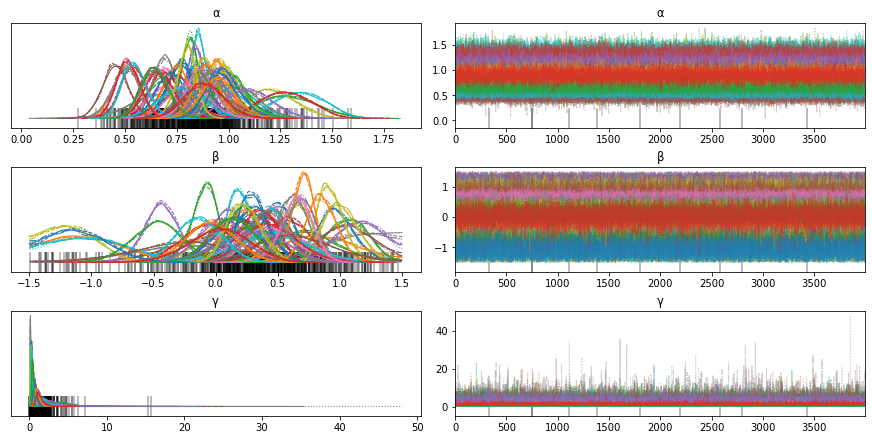

In [6]:
az.plot_trace(trace, var_names=['α','β','γ'])

In [7]:
with RiskAmb:
    ppc = pm.sample_posterior_predictive(trace)

<AxesSubplot:xlabel='choice / choice'>

/home/nachshon/anaconda3/envs/risk/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


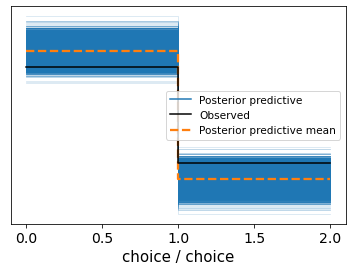

In [8]:
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=RiskAmb))

In [49]:
df = db[['sub','subn']].sort_values('subn').drop_duplicates().reset_index(drop=True)
df.shape

(64, 2)

In [51]:
age = pd.read_excel('/media/Data/Lab_Projects/Aging/aging_session_log.xlsx', sheet_name='scans').iloc[:, [1,7,8]]
age.columns.values[0] = "sub"
age['sub'] = age['sub'].map(lambda x: int(x.lstrip('AG_')))
age.head()

,sub,Age,Male
0,10,18.742466,1
1,11,43.301370,0
2,12,23.147945,1
3,13,48.684932,0
4,14,26.558904,0


In [103]:
age = pd.read_excel('/media/Data/Lab_Projects/Aging/aging_session_log.xlsx', sheet_name='sessions').iloc[:,[0,7,9]]
age.columns.values[0] = "sub"
age = age[age.gender != 'gender']
age = age.dropna().reset_index()
age['sub'] = age['sub'].map(lambda x: int(x.lstrip('AG_')))
age = age.drop(['index'], axis=1)

age

,sub,gender,age
0,10,M,18
1,11,F,43
2,12,M,23
3,13,F,48
4,14,F,26
...,...,...,...
71,87,F,50
72,88,M,71
73,89,M,82
74,91,M,83


In [97]:
age.to_csv('data/age.csv')

In [98]:
list(set(age['sub']) - set(df['sub']))

[65, 40, 73, 11, 12, 14, 16, 17, 50, 52, 27, 29]

In [113]:
df = db[['sub','subn']].sort_values('subn').drop_duplicates().reset_index(drop=True)

#age = pd.read_excel('/media/Data/Lab_Projects/Aging/aging_session_log.xlsx', sheet_name='scans').iloc[:, [1,7,8]]
#age.columns.values[0] = "sub"
#age['sub'] = age['sub'].map(lambda x: int(x.lstrip('AG_')))

df = df.merge(age, left_on='sub', right_on='sub')
df['age'] = df.age.astype('int')

df.shape

(64, 4)

In [114]:
alpha = az.summary(trace, var_names=['α'])[['mean','sd']]
beta = az.summary(trace, var_names=['β'])[['mean','sd']]
gamma = az.summary(trace, var_names=['γ'])[['mean','sd']]

alpha = alpha.rename(columns={'mean': "alpha_pymc", 'sd': 'alpha_sd'}).reset_index(drop=True)
beta = beta.rename(columns={'mean': "beta_pymc", 'sd': 'beta_sd'}).reset_index(drop=True)
gamma = gamma.rename(columns={'mean': "gamma_pymc", 'sd': 'gamma_sd'}).reset_index(drop=True)


df = df.merge(alpha, left_index=True, right_index=True)
df = df.merge(beta, left_index=True, right_index=True)
df = df.merge(gamma, left_index=True, right_index=True)

df = df.merge(mLL, left_on='sub', right_on='sub')
print(df.shape)
df.head()

(64, 13)


,sub,subn,gender,age,alpha_pymc,alpha_sd,beta_pymc,beta_sd,gamma_pymc,gamma_sd,alpha_mll,beta_mll,gamma_mll
0,10,0,M,18,0.886,0.064,0.482,0.138,0.566,0.161,1.045661,0.702968,-0.913220
1,13,1,F,48,0.889,0.114,0.408,0.291,2.242,0.929,0.000000,-1.500000,1.635940
2,15,2,F,58,0.684,0.092,0.721,0.264,1.049,0.378,0.480626,-1.500000,0.618761
3,18,3,F,83,0.545,0.065,0.238,0.202,0.450,0.135,0.000000,1.500000,-1.275216
4,19,4,M,32,0.837,0.077,0.391,0.177,0.767,0.224,0.000000,-1.500000,0.748016


In [106]:
df.to_csv('data/rna_alpha.csv')

In [115]:
df.age

0     18
1     48
2     58
3     83
4     32
      ..
59    50
60    71
61    82
62    83
63    86
Name: age, Length: 64, dtype: int64

In [21]:
ifat = pd.read_csv('data/Aging_021722.txt', sep='\t')
df = df.merge(ifat, left_on='sub', right_on='subject')

In [116]:
df.corr()

,sub,subn,age,alpha_pymc,alpha_sd,beta_pymc,beta_sd,gamma_pymc,gamma_sd,alpha_mll,beta_mll,gamma_mll
sub,1.000000,0.999328,0.216564,0.071032,-0.077991,-0.099670,-0.089775,-0.061813,-0.086551,0.192726,0.049555,-0.219459
subn,0.999328,1.000000,0.212073,0.065272,-0.084549,-0.104350,-0.087169,-0.066630,-0.090072,0.191965,0.057768,-0.224047
age,0.216564,0.212073,1.000000,-0.207037,0.171257,-0.019479,0.324976,0.273487,0.246786,-0.054819,-0.179375,-0.098447
alpha_pymc,0.071032,0.065272,-0.207037,1.000000,0.481254,-0.098471,-0.199580,0.370050,0.248383,0.093422,-0.170875,0.490112
alpha_sd,-0.077991,-0.084549,0.171257,0.481254,1.000000,-0.105896,0.669994,0.890853,0.842694,-0.349230,-0.376530,0.483676
beta_pymc,-0.099670,-0.104350,-0.019479,-0.098471,-0.105896,1.000000,-0.287914,-0.130181,-0.181703,0.145637,-0.238897,-0.061769
beta_sd,-0.089775,-0.087169,0.324976,-0.199580,0.669994,-0.287914,1.000000,0.705291,0.774419,-0.370578,-0.174612,0.197205
gamma_pymc,-0.061813,-0.066630,0.273487,0.370050,0.890853,-0.130181,0.705291,1.000000,0.962346,-0.242121,-0.303354,0.474211
gamma_sd,-0.086551,-0.090072,0.246786,0.248383,0.842694,-0.181703,0.774419,0.962346,1.000000,-0.214975,-0.198894,0.378003
alpha_mll,0.192726,0.191965,-0.054819,0.093422,-0.349230,0.145637,-0.370578,-0.242121,-0.214975,1.000000,0.180605,-0.232298


In [117]:
prop = db.groupby(['sub','ambiguity','risk','value'], as_index=False)['choice'].mean()
prop.head()

,sub,ambiguity,risk,value,choice
0,10,0.0,0.25,5,0.00
1,10,0.0,0.25,8,0.00
2,10,0.0,0.25,12,0.00
3,10,0.0,0.25,25,0.75
4,10,0.0,0.50,5,0.00


In [118]:
subs = df['sub'].unique().tolist()
prop = prop[prop['sub'].isin(subs)].reset_index()

/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipyke

/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipyke

/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipyke

/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipyke

/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipyke

/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipyke

/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipyke

/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipyke

/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipyke

/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipyke

/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipyke

/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipyke

/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipyke

/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipyke

/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipyke

/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipyke

/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipyke

/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipyke

/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipyke

/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipyke

/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipyke

/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipyke

/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipyke

/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipyke

/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipyke

/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipyke

/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipyke

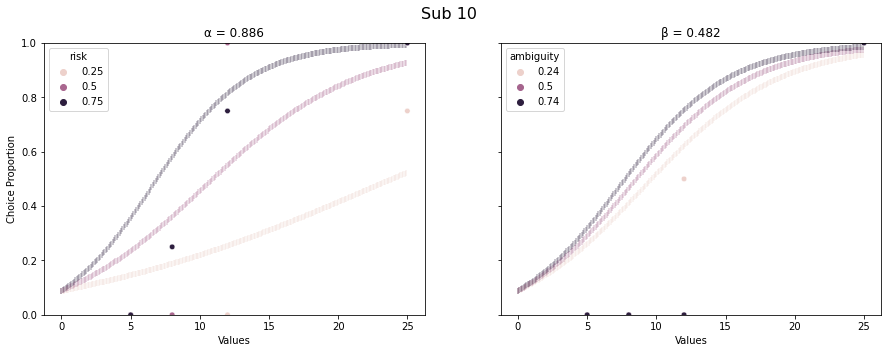

/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipyke

/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipyke

/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipyke

/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipyke

/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipyke

/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipyke

/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipyke

/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipyke

/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipyke

/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipyke

/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipyke

/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipyke

/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipyke

/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipyke

/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipyke

/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipyke

/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipyke

/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipyke

/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipyke

/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipyke

/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipyke

/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipyke

/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipyke

/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipyke

/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipyke

/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipyke

/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipyke

/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figA = figA.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipykernel_592921/47164896.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  figR = figR.append(temp)
/tmp/ipyke

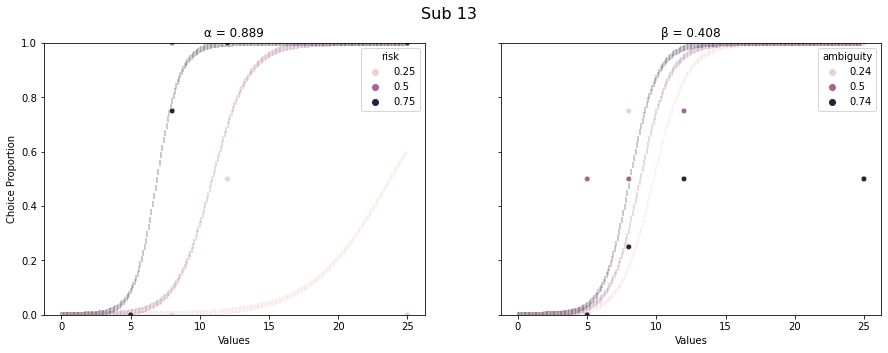

In [119]:
risks     = [0.25, 0.5, 0.75]
ambiguity = [0.24, 0.5, 0.74]

for sub in subs[:2]:
    
    figR=pd.DataFrame()
    figA=pd.DataFrame()
    
    f, ax = plt.subplots(1, 2, figsize=(15, 5),sharey=True)

    alpha  = float(df[df['sub']==sub]['alpha_pymc'])
    beta   = float(df[df['sub']==sub]['beta_pymc'])
    gamma  = float(df[df['sub']==sub]['gamma_pymc'])
    
    for value in np.arange(0, 25, 0.1):
        for risk in risks:
            svLotto = risk * value ** alpha
            svRef   = 5 ** alpha
            p = special.expit((svLotto - svRef) * gamma)
            temp = pd.DataFrame({'x': value, 'y': p,'risk':risk}, index=[0])
            figR = figR.append(temp)
        
        for amb in ambiguity:
            svLotto = (0.5 + beta * amb/2) * value ** alpha
            svRef   = 5 ** alpha
            p = special.expit((svLotto - svRef) * gamma)
            temp = pd.DataFrame({'x': value, 'y': p,'ambiguity':amb}, index=[0])
            figA = figA.append(temp)
    
    f.suptitle('Sub {}'.format(sub), fontsize=16)
    sns.scatterplot(x='x', y='y', data=figR, hue='risk', ax=ax[0], legend = False, marker="|")  
    sns.scatterplot(x='x', y='y', data=figA, hue='ambiguity', ax=ax[1], legend = False, marker="|") 
    
    fig = prop[prop['sub']==sub]
    figR = fig[fig['ambiguity']==0]
    figA = fig[fig['ambiguity'] > 0]
    
    sns.scatterplot(x='value', y='choice', data=figR, hue='risk', ax=ax[0], s=30)
    sns.scatterplot(x='value', y='choice', data=figA, hue='ambiguity', ax=ax[1], s=30)
    
    ax[0].set(xlabel="Values", ylabel="Choice Proportion", title="α = {}".format(alpha), ylim=(0,1))
    ax[1].set(xlabel="Values", title="β = {}".format(beta))
    plt.show()

In [120]:
pp=[]
pll = []    

for i in range(prop.shape[0]):
    sub = prop['sub'][i]
    alpha = float(df[df['sub']==sub]['alpha_pymc'])
    beta  = float(df[df['sub']==sub]['beta_pymc'])
    svLotto = (prop.risk[i] + beta * prop.ambiguity[i]/2) * prop.value[i] ** alpha
    svRef   = 5 ** alpha
    p = special.expit((svLotto - svRef))
    pp.append(p)
    
    alpha = float(df[df['sub']==sub]['alpha_mll'])
    beta  = float(df[df['sub']==sub]['beta_mll'])
    svLotto = (prop.risk[i] + beta * prop.ambiguity[i]/2) * prop.value[i] ** alpha
    svRef   = 5 ** alpha
    p = special.expit((svLotto - svRef))
    pll.append(p)
                      
prop['pymc'] = pp
prop['mll'] = pll
prop.head(10)

,index,sub,ambiguity,risk,value,choice,pymc,mll
0,0,10,0.0,0.25,5,0.00,0.042233,0.017362
1,1,10,0.0,0.25,8,0.00,0.070178,0.039846
2,2,10,0.0,0.25,12,0.00,0.129890,0.117033
3,3,10,0.0,0.25,25,0.75,0.542003,0.865094
4,4,10,0.0,0.50,5,0.00,0.110964,0.063528
5,5,10,0.0,0.50,8,0.00,0.267749,0.272323
6,6,10,0.0,0.50,12,1.00,0.588555,0.792428
7,7,10,0.0,0.50,25,1.00,0.988999,0.999888
8,8,10,0.0,0.75,5,0.00,0.261060,0.206637
9,9,10,0.0,0.75,8,0.25,0.639183,0.771418


In [121]:
r2pymc = pd.DataFrame()
for s in subs:
    
    pro = prop[prop['sub']==s]
    r2 = np.corrcoef(pro.choice, pro.pymc)[0][1]
    r2mll = np.corrcoef(pro.choice, pro.mll)[0][1]
    temp = pd.DataFrame({'sub': s, 
                        'r2pymc': r2,
                        'r2mll': r2mll}, index=[0])
    r2pymc = r2pymc.append(temp)
    
df = df.merge(r2pymc, left_on='sub', right_on='sub')
df.head()

/tmp/ipykernel_592921/1192849893.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  r2pymc = r2pymc.append(temp)
/tmp/ipykernel_592921/1192849893.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  r2pymc = r2pymc.append(temp)
/tmp/ipykernel_592921/1192849893.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  r2pymc = r2pymc.append(temp)
/tmp/ipykernel_592921/1192849893.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  r2pymc = r2pymc.append(temp)
/tmp/ipykernel_592921/1192849893.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  r2pymc = 

/tmp/ipykernel_592921/1192849893.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  r2pymc = r2pymc.append(temp)
/tmp/ipykernel_592921/1192849893.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  r2pymc = r2pymc.append(temp)
/tmp/ipykernel_592921/1192849893.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  r2pymc = r2pymc.append(temp)
/tmp/ipykernel_592921/1192849893.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  r2pymc = r2pymc.append(temp)
/tmp/ipykernel_592921/1192849893.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  r2pymc = 

,sub,subn,gender,age,alpha_pymc,alpha_sd,beta_pymc,beta_sd,gamma_pymc,gamma_sd,alpha_mll,beta_mll,gamma_mll,r2pymc,r2mll
0,10,0,M,18,0.886,0.064,0.482,0.138,0.566,0.161,1.045661,0.702968,-0.913220,0.771179,0.714589
1,13,1,F,48,0.889,0.114,0.408,0.291,2.242,0.929,0.000000,-1.500000,1.635940,0.650290,0.351954
2,15,2,F,58,0.684,0.092,0.721,0.264,1.049,0.378,0.480626,-1.500000,0.618761,0.322593,0.612059
3,18,3,F,83,0.545,0.065,0.238,0.202,0.450,0.135,0.000000,1.500000,-1.275216,0.759268,0.067638
4,19,4,M,32,0.837,0.077,0.391,0.177,0.767,0.224,0.000000,-1.500000,0.748016,0.828468,0.362902


In [122]:
np.mean(df.r2pymc)

0.6862243573286189

In [123]:
np.mean(df.r2mll)

0.49124450696494437

<AxesSubplot:xlabel='age', ylabel='alpha_pymc'>

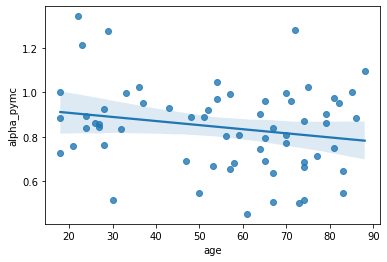

In [125]:
sns.regplot(x = 'age', y = 'alpha_pymc', data = df)

In [127]:
pg.corr(df.age, df.alpha_pymc, alternative='two-sided', method='pearson')

,n,r,CI95%,p-val,BF10,power
pearson,64,-0.207037,"[-0.43, 0.04]",0.100695,0.583,0.378994


In [53]:
freesurfer = pd.read_csv('data/aprac.txt', sep='\t')
freesurfer['sub'] = [s.replace('sub-' , '') for s in sup['rh.aparc.a2009s.thickness']]

sup = freesurfer[['sub','rh_G_parietal_sup_thickness','eTIV']]
sup.head()

,sub,rh_G_parietal_sup_thickness,eTIV
0,10,2.259,1.722888e+06
1,11,2.263,1.358734e+06
2,13,1.995,1.275879e+06
3,14,2.288,1.574182e+06
4,15,2.099,1.637665e+06


In [56]:
sup['sub'] = sup['sub'].astype(int)
df2 = df.merge(sup, left_on='sub', right_on='sub')
df2.head()

/tmp/ipykernel_253441/3656633057.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sup['sub'] = sup['sub'].astype(int)


,sub,subn,Age,Male,alpha_pymc,alpha_sd,beta_pymc,beta_sd,gamma_pymc,gamma_sd,...,gamma_mll,subject,alpha,beta,slope,r2,r2pymc,r2mll,rh_G_parietal_sup_thickness,eTIV
0,10,0,18.742466,1,0.889,0.064,0.490,0.136,0.573,0.164,...,-0.913217,10,0.889722,0.520942,-1.955494,0.666511,0.769147,0.714589,2.259,1.722888e+06
1,13,1,48.684932,0,0.896,0.115,0.426,0.286,2.283,0.980,...,1.635946,13,1.028045,0.670166,-0.338559,0.198659,0.649345,0.351954,1.995,1.275879e+06
2,15,2,58.394521,0,0.685,0.094,0.734,0.272,1.061,0.374,...,0.618762,15,0.674981,0.720106,-1.095697,0.293179,0.320635,0.612059,2.099,1.637665e+06
3,18,3,83.169863,0,0.544,0.065,0.242,0.205,0.452,0.137,...,-1.275214,18,0.499448,0.106756,-2.961613,0.480662,0.758523,0.067638,2.034,1.438339e+06
4,19,4,32.167123,1,0.840,0.077,0.396,0.177,0.774,0.229,...,0.748017,19,0.841002,0.425222,-1.415259,0.509504,0.828301,0.362902,2.201,1.820525e+06


In [66]:
pg.partial_corr(data=df2,x='alpha_pymc',y='rh_G_parietal_sup_thickness',covar=['eTIV','Age'])
#pg.corr(df2.Age, df2.eTIV)

,n,r,CI95%,p-val
pearson,31,0.124666,"[-0.25, 0.47]",0.519358
